# Imports

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

In [60]:
# figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_theme(style="whitegrid")
sns.set_palette(palette="Paired")

# set seed
np.random.seed(42)

# Load Data

In [61]:
X_train = pd.read_csv("../../data/processed/train_data_cleaned.csv")
y_train = pd.read_csv("../../data/processed/train_labels.csv")

In [62]:
X_train = X_train.iloc[:100000] # max 260601
y_train = y_train.iloc[:100000] # max 260601

# Random Forest

In [63]:
# Build random forest classifier
rf = RandomForestClassifier(n_estimators=100,
                            max_depth=20,
                            max_features="sqrt",
                            random_state=42,
                            n_jobs=-1,
                            verbose=1)

In [64]:
# Perform cross validation
cv_results = cross_validate(rf,
                            X_train,
                            y_train["damage_grade"],
                            cv=5,
                            scoring=("accuracy", "matthews_corrcoef"),
                            return_train_score=True,
                            n_jobs=-1,
                            verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.6s finished


In [65]:
# Display results
cv_results = pd.DataFrame(cv_results).reset_index(names="k-fold")
display(cv_results)

# Calculate mean and standard deviation
cv_acc_mean_rf = cv_results["test_accuracy"].mean()
cv_acc_std_rf = cv_results["test_accuracy"].std()
print(f"Mean Accuracy: {cv_acc_mean_rf:.3f} +/- {cv_acc_std_rf:.3f}")

cv_mcc_mean_rf = cv_results["test_matthews_corrcoef"].mean()
cv_mcc_std_rf = cv_results["test_matthews_corrcoef"].std()
print(f"Mean MCC: {cv_mcc_mean_rf:.3f} +/- {cv_mcc_std_rf:.3f}")

,k-fold,fit_time,score_time,test_accuracy,train_accuracy,test_matthews_corrcoef,train_matthews_corrcoef
0,0,7.655315,0.071138,0.70305,0.896463,0.438359,0.813120
1,1,5.479035,0.335590,0.69855,0.898988,0.429471,0.817731
2,2,5.344997,0.470634,0.70215,0.894900,0.435110,0.809776
3,3,5.449043,0.389599,0.70195,0.897600,0.435248,0.815072
4,4,5.418516,0.406116,0.69795,0.897388,0.427764,0.814421


Mean Accuracy: 0.701 +/- 0.002
Mean MCC: 0.433 +/- 0.004


**Plot results**

In [66]:
# Melt the dataset to create a long-form version for plotting
df_melt = cv_results[["k-fold", "test_accuracy", "test_matthews_corrcoef"]].melt(id_vars='k-fold', var_name='Metric', value_name='Score')

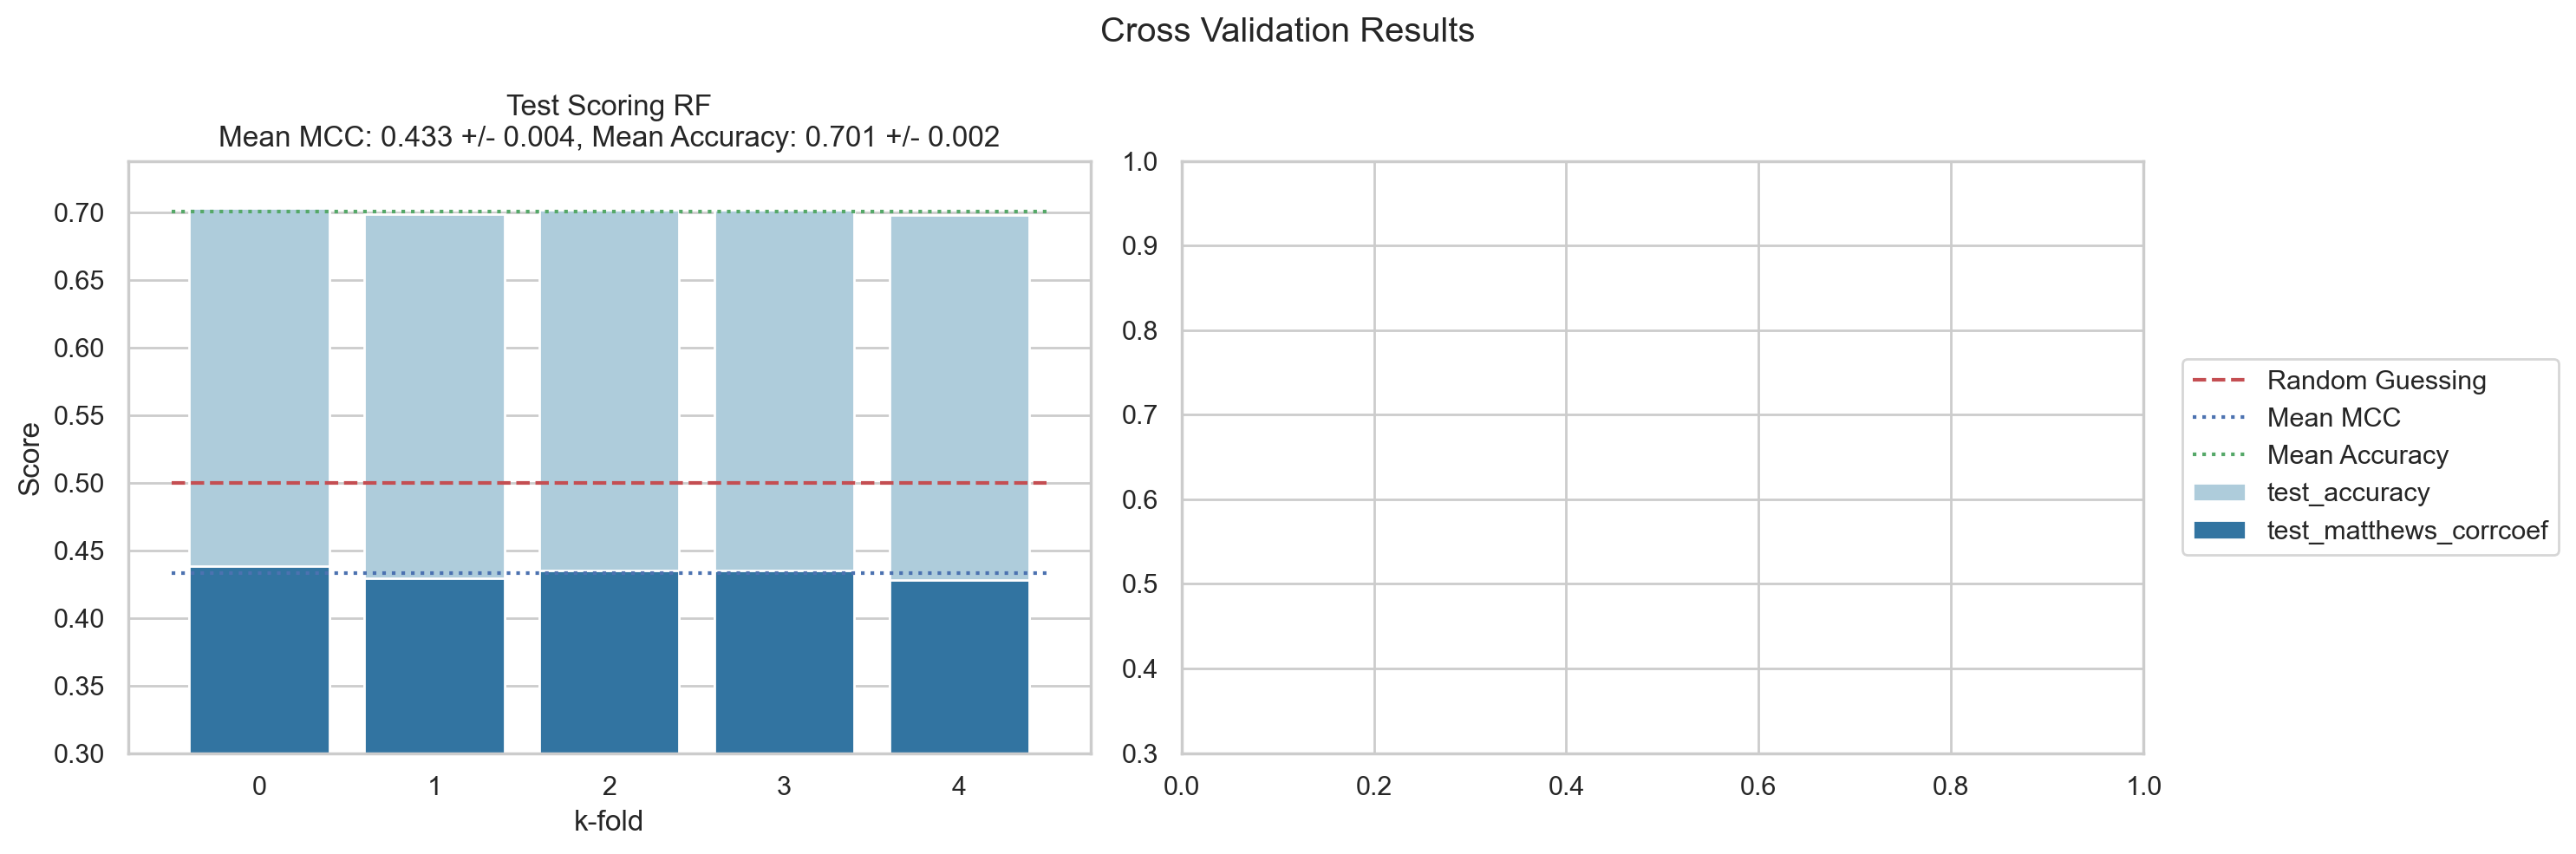

In [80]:
# Create figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot a stacked bar chart using Seaborn
fig_ax1 = sns.barplot(x='k-fold', y='Score', hue='Metric', data=df_melt, ax=axes[0], dodge=False, errorbar=None)
axes[0].set_title("Test Scoring RF" + "\n" +
                  f"Mean MCC: {cv_mcc_mean_rf:.3f} +/- {cv_mcc_std_rf:.3f}, Mean Accuracy: {cv_acc_mean_rf:.3f} +/- {cv_acc_std_rf:.3f}")
axes[0].legend().set_visible(False)

# Add horizontal guidelines for interpretation
# Get x min and x max
xmin, xmax = axes[0].get_xlim()
# Performance guide lines
axes[0].hlines(y=0.5, xmin=xmin, xmax=xmax, linestyles="dashed", colors='r', label="Random Guessing")
# Mean guidelines
axes[0].hlines(y=cv_mcc_mean_rf, xmin=xmin, xmax=xmax, linestyles="dotted", colors='b', label="Mean MCC")
axes[0].hlines(y=cv_acc_mean_rf, xmin=xmin, xmax=xmax, linestyles="dotted", colors='g', label="Mean Accuracy")

plt.suptitle("Cross Validation Results")
plt.setp(axes, ylim=(0.3))
handles, labels = axes[0].get_legend_handles_labels()
plt.legend(handles, labels, bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

plt.tight_layout()
plt.show()

# Xgboost